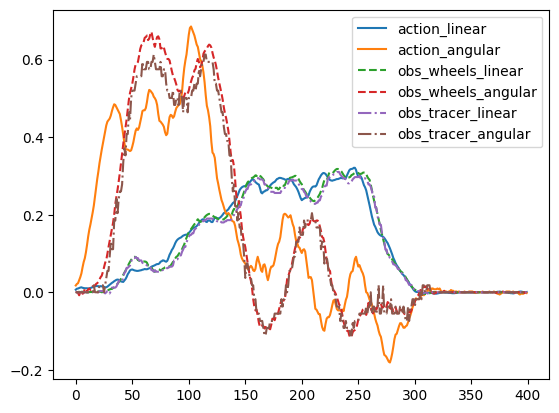

In [1]:
import h5py
import matplotlib.pyplot as plt

with h5py.File('/home/mobile-aloha/data/aloha_mobile_fork/episode_19_replayed.hdf5', 'r') as f:
    obs_wheels = f['obs_wheels'][:]
    obs_tracer = f['obs_tracer'][:]
    base_actions = f['base_action'][:]

    plt.plot(base_actions[:, 0], label='action_linear')
    plt.plot(base_actions[:, 1], label='action_angular')
    plt.plot(obs_wheels[:, 0], '--', label='obs_wheels_linear')
    plt.plot(obs_wheels[:, 1], '--', label='obs_wheels_angular')
    plt.plot(obs_tracer[:, 0], '-.', label='obs_tracer_linear')
    plt.plot(obs_tracer[:, 1], '-.', label='obs_tracer_angular')
    plt.legend()

    plt.show()

In [23]:
import pyrealsense2 as rs
from pyquaternion import Quaternion
import numpy as np
np.set_printoptions(precision=3, suppress=True)

In [22]:
import pyagxrobots
tracer = pyagxrobots.pysdkugv.TracerBase()
tracer.EnableCAN()

SocketcanBus was not properly shut down


In [24]:
pipeline = rs.pipeline()
cfg = rs.config()
# if only pose stream is enabled, fps is higher (202 vs 30)
cfg.enable_stream(rs.stream.pose)
pipeline.start(cfg)


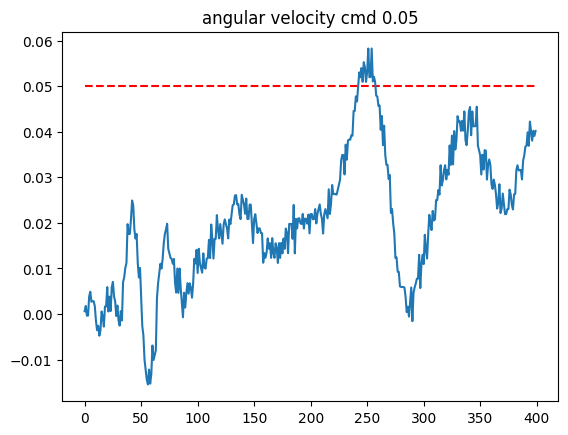

Exception in callback Notifier._on_message_available(<can.interfac...x7f2d67030970>)
handle: <Handle Notifier._on_message_available(<can.interfac...x7f2d67030970>)>
Traceback (most recent call last):
  File "/home/mobile-aloha/miniconda3/envs/aloha/lib/python3.8/site-packages/can/interfaces/socketcan/socketcan.py", line 531, in capture_message
    cf, ancillary_data, msg_flags, addr = sock.recvmsg(
OSError: [Errno 19] No such device

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/mobile-aloha/miniconda3/envs/aloha/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mobile-aloha/miniconda3/envs/aloha/lib/python3.8/site-packages/can/notifier.py", line 137, in _on_message_available
    msg = bus.recv(0)
  File "/home/mobile-aloha/miniconda3/envs/aloha/lib/python3.8/site-packages/can/bus.py", line 98, in recv
    msg, already_filtered = self._recv_internal(

In [41]:
import time
set_vel = 0.05
l = []
for _ in range(400):
    frames = pipeline.wait_for_frames()
    pose_frame = frames.get_pose_frame()
    pose = pose_frame.get_pose_data()
    q1 = Quaternion(w=pose.rotation.w, x=pose.rotation.x, y=pose.rotation.y, z=pose.rotation.z)
    rotation = -np.array(q1.yaw_pitch_roll)[0]
    rotation_vec = np.array([np.cos(rotation), np.sin(rotation)])
    linear_vel_vec = np.array([pose.velocity.z, pose.velocity.x])
    is_forward = rotation_vec.dot(linear_vel_vec) > 0
    base_linear_vel = np.sqrt(pose.velocity.z ** 2 + pose.velocity.x ** 2) * (1 if is_forward else -1)
    base_angular_vel = pose.angular_velocity.y
    # print(rotation * 180 / np.pi, pose.angular_velocity.y, linear_vel_vec, is_forward, base_linear_vel)
    # print(base_angular_vel)
    l.append(base_angular_vel)
    tracer.SetMotionCommand(linear_vel=0, angular_vel=set_vel)
    time.sleep(0.02)
from matplotlib import pyplot as plt
plt.title(f'angular velocity cmd {set_vel}')
plt.plot([set_vel] * len(l), linestyle='--', color='red')
plt.plot(l)
plt.savefig(f'angular_velocity_{set_vel}.png')

In [10]:
from simple_pid import PID
pid = PID(1, 0.1, 0.05, setpoint=np.array([2,2]))
action = pid(np.array([0., 0.]))
action

array([2., 2.])

In [6]:
frames = pipeline.wait_for_frames()
pose_frame = frames.get_pose_frame()
pose = pose_frame.get_pose_data()
pose.translation, pose.rotation

(x: -3.06888e-06, y: -0.000150881, z: 0.000225695,
 x: 0.707983, y: 0.00377035, z: 0.00379921, w: 0.70621)

In [4]:
frames = pipeline.wait_for_frames()
pose_frame = frames.get_pose_frame()
pose = pose_frame.get_pose_data()
pose.translation, pose.rotation

(x: -0.0135755, y: 0.00177098, z: 0.321237,
 x: 0.709958, y: 0.000801042, z: 0.0116255, w: 0.704148)

In [5]:
frames = pipeline.wait_for_frames()
pose_frame = frames.get_pose_frame()
pose = pose_frame.get_pose_data()
pose.translation, pose.rotation

(x: 0.370863, y: 0.0132695, z: 0.967719,
 x: 0.662497, y: 0.256232, z: -0.253257, w: 0.656737)

In [49]:
q1 = Quaternion(w=pose.rotation.w, x=pose.rotation.x, y=pose.rotation.y, z=pose.rotation.z)
np.array(q1.yaw_pitch_roll) * 180 / np.pi


array([-178.554,   -0.039,   89.406])

In [10]:
q1 = Quaternion(w=pose.rotation.w, x=pose.rotation.x, y=pose.rotation.y, z=pose.rotation.z)
np.array(q1.yaw_pitch_roll) * 180 / np.pi

array([-0.315,  0.227, 90.26 ])